# Train Algorithm Selection for the Golfer Problem

Our training data consists of the feature of an instance of the Social Golfer Problem. The target class is the algorithm that performed better on this instance. 

Target:
- `0`: MiniZinc
- `1`: Simmulated Annealing


In [122]:
import pandas as pd
from matplotlib import pyplot  as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [123]:
# load training data

df = pd.read_csv("../data/training/training_data_v0002.csv", index_col="instance_id")
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.65,
    random_state=20,
    shuffle=True,
    stratify=y # preserve target class distribution
)

## Explore Training Data

In [124]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,n_groups,n_per_group,n_rounds,n_players,groups_to_players,rounds_to_players,distinct_pairs,pair_capacity,target
instance_id,,,,,,,,,
g99,5,4,10,20,0.250000,0.500000,190,300,1
g188,8,2,9,16,0.500000,0.562500,120,72,1
g122,6,3,6,18,0.333333,0.333333,153,108,1
g128,6,4,3,24,0.250000,0.125000,276,108,1
g92,5,4,3,20,0.250000,0.150000,190,90,1


In [125]:
print("shape: ", df_train.shape)
print(df_train.info())
df_train.describe().T

shape:  (140, 9)
<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, g99 to g136
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   n_groups           140 non-null    int64  
 1   n_per_group        140 non-null    int64  
 2   n_rounds           140 non-null    int64  
 3   n_players          140 non-null    int64  
 4   groups_to_players  140 non-null    float64
 5   rounds_to_players  140 non-null    float64
 6   distinct_pairs     140 non-null    int64  
 7   pair_capacity      140 non-null    int64  
 8   target             140 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 10.9+ KB
None


,count,mean,std,min,25%,50%,75%,max
n_groups,140.0,5.500000,1.602606,3.000000,4.0,5.50000,7.000000,8.00
n_per_group,140.0,3.578571,1.125684,2.000000,3.0,4.00000,5.000000,5.00
n_rounds,140.0,5.978571,2.468413,2.000000,4.0,6.00000,8.000000,10.00
n_players,140.0,19.700000,8.740627,6.000000,12.0,18.00000,25.000000,40.00
groups_to_players,140.0,0.313810,0.113883,0.200000,0.2,0.25000,0.333333,0.50
rounds_to_players,140.0,0.365704,0.222961,0.057143,0.2,0.31625,0.500000,1.25
distinct_pairs,140.0,222.121429,194.017223,15.000000,66.0,153.00000,300.000000,780.00
pair_capacity,140.0,177.257143,160.038097,6.000000,53.0,120.00000,256.500000,800.00
target,140.0,0.942857,0.232949,0.000000,1.0,1.00000,1.000000,1.00


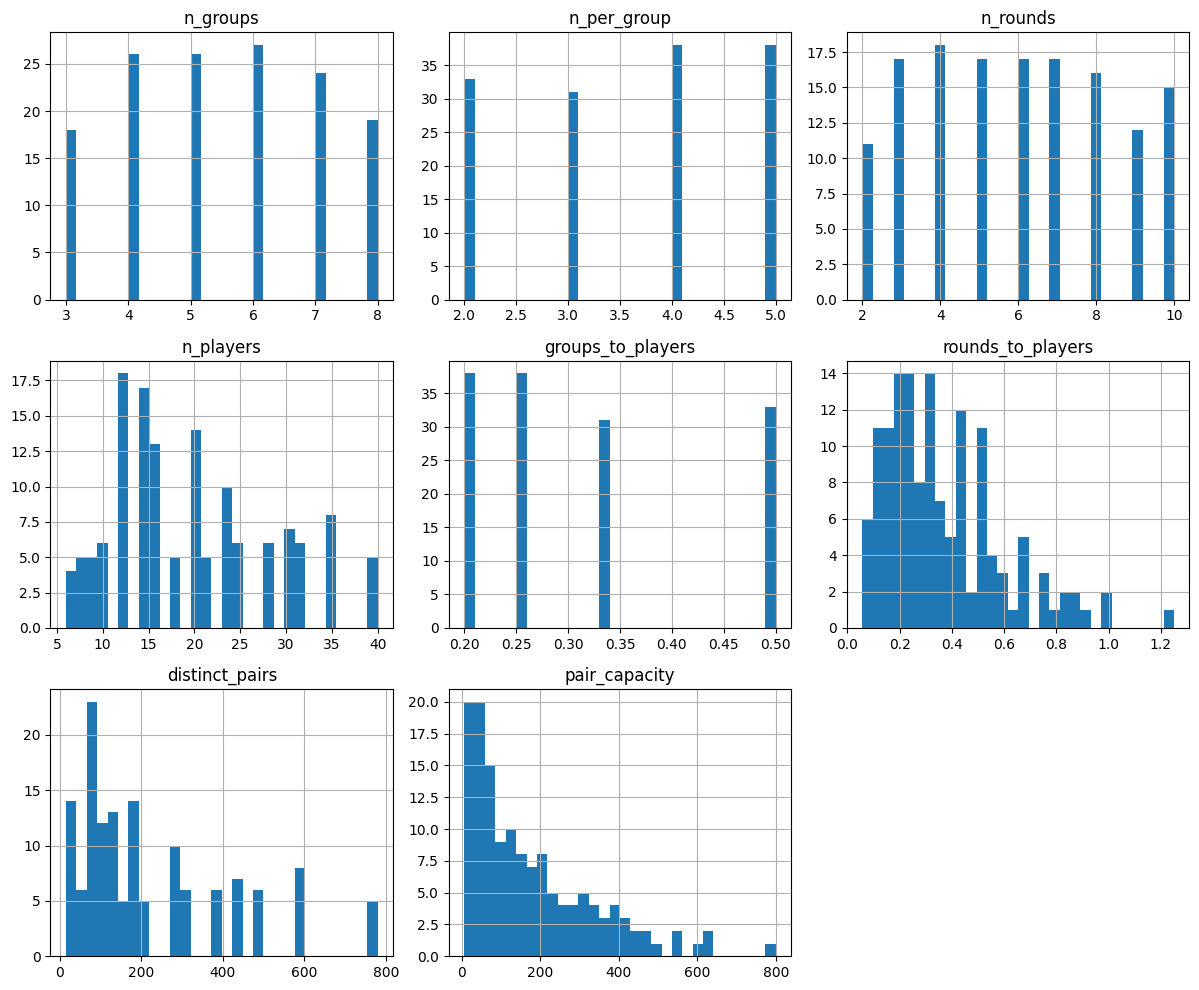

In [126]:
# Feature Distribution
num_cols = df_train.select_dtypes(include=np.number).columns.drop("target")

# Histograms
df_train[num_cols].hist(figsize=(12,10), bins=30)
plt.tight_layout()
plt.show()

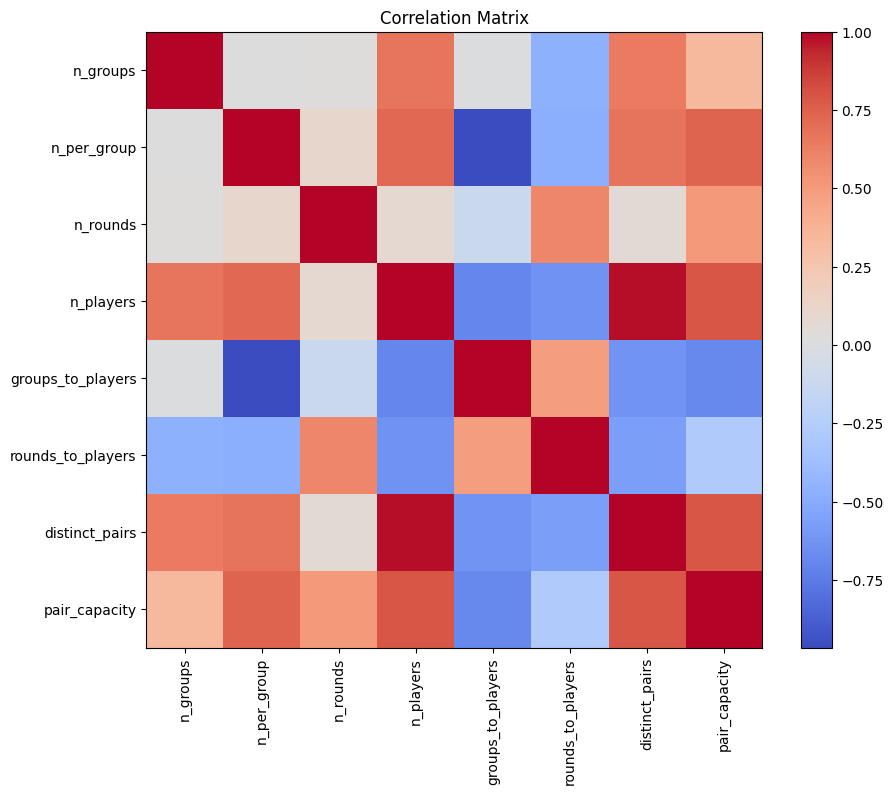


Correlation with target:
 target               1.000000
n_per_group          0.291597
n_players            0.228252
pair_capacity        0.207652
distinct_pairs       0.200720
n_groups             0.038541
n_rounds            -0.027168
rounds_to_players   -0.224505
groups_to_players   -0.313541
Name: target, dtype: float64


In [127]:
corr = X_train[num_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix")
plt.show()

# Correlation with target (if target numeric or binary 0/1)
target_corr = X_train.join(y_train).corr()[y_train.name].sort_values(ascending=False)
print("\nCorrelation with target:\n", target_corr)

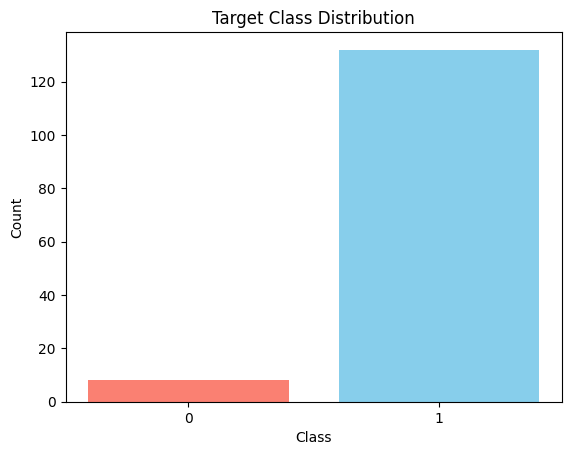

target
1    0.942857
0    0.057143
Name: proportion, dtype: float64


In [128]:
# Target Distribution 

counts = y_train.value_counts()
plt.bar(counts.index, counts.values, color=['skyblue', 'salmon'])
plt.xticks([0,1])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Target Class Distribution")
plt.show()

print(y_train.value_counts(normalize=True))

### Analysis

The target class is highly imbalanced. For 95% of instances the better algorithm is simulated annealing and the rest is minizinc.

## Model & Training

In [129]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Preprocessing: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model: Random Forest with class weights for imbalance
model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluation Auto ML

CV F1-macro: 0.663 (+/- 0.287)

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.99      0.97      0.98        72

    accuracy                           0.96        76
   macro avg       0.79      0.86      0.82        76
weighted avg       0.97      0.96      0.96        76



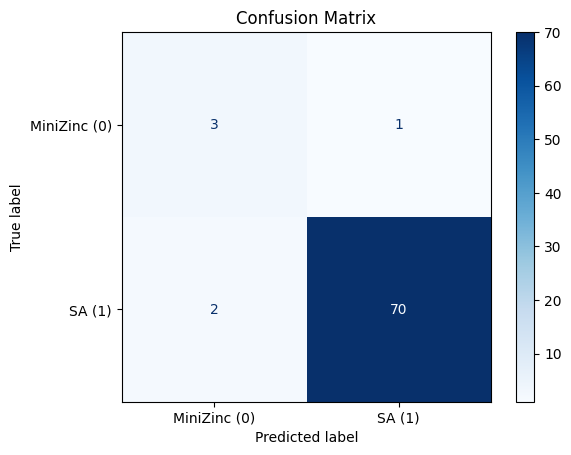

target
1    72
0     4
Name: count, dtype: int64

In [ ]:
# Cross-validation on train (stratified 3-fold, F1 macro for imbalance)

# Use stratifiedKFold to keep target class proportion
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='f1_macro')
print(f"CV F1-macro: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Predictions and Evaluation
y_pred = model.predict(X_test_scaled)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MiniZinc (0)', 'SA (1)'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


Feature Importances:
              feature  importance
7      pair_capacity    0.250928
3          n_players    0.150463
5  rounds_to_players    0.141877
1        n_per_group    0.118968
2           n_rounds    0.118579
6     distinct_pairs    0.087172
0           n_groups    0.073178
4  groups_to_players    0.058835


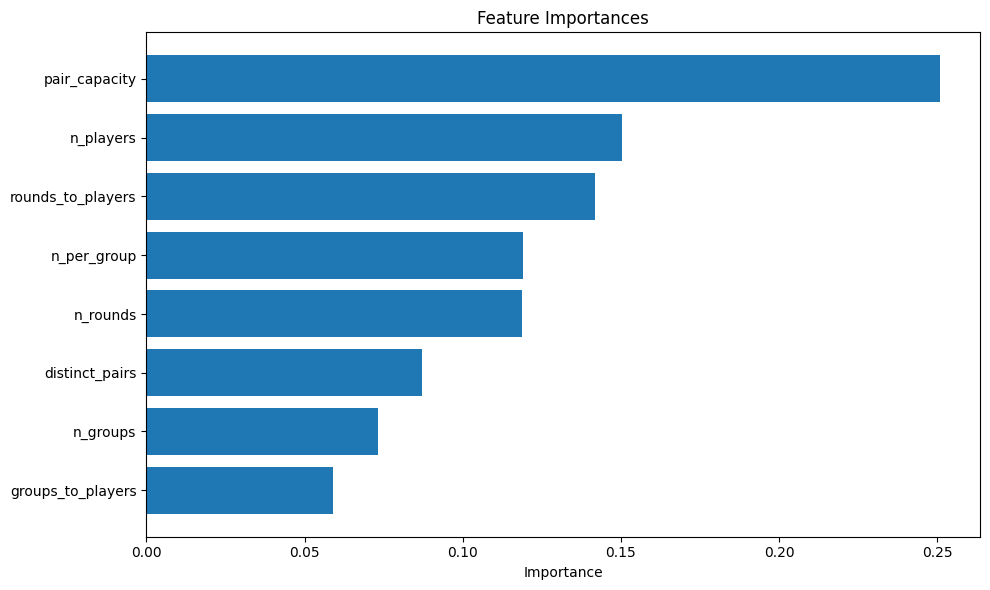

In [131]:
# Feature Importances
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importances:\n", importances)

# Plot Feature Importancels
plt.figure(figsize=(10, 6))
plt.barh(importances['feature'], importances['importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()

The model achieves high overall accuracy (0.96), performing very well on the majority class Simulated Annealing (F1 0.98). For the minority class, MiniZinc, F1 is lower (0.67) due to very few samples, though most are correctly identified (recall 0.75). The 3-cross-fold validation resulted in a F1 score of 0.68.

For the test data, the model was able to classify 70 SA instances correctly but failed for two. 

The feature that is most important for this model is pair_capacity.

## Comparison: Complete, Heuristic, AlgorithmSelector

In [132]:
# Predict on test set
y_pred = model.predict(X_test_scaled)

# Create a DataFrame with actual, predicted, and features
results = X_test.copy()  # keep original features
results['y_true'] = y_test
results['y_pred'] = y_pred

# Filter misclassified instances
misclassified = results[results['y_true'] != results['y_pred']]

# Display misclassified instances with their features
display(misclassified)

,n_groups,n_per_group,n_rounds,n_players,groups_to_players,rounds_to_players,distinct_pairs,pair_capacity,y_true,y_pred
instance_id,,,,,,,,,,
g120,6,3,4,18,0.333333,0.222222,153,72,0,1
g43,4,2,8,8,0.500000,1.000000,28,32,1,0
g79,5,2,8,10,0.500000,0.800000,45,40,1,0


In [138]:
ev_df = pd.read_csv('../data/evaluation/0002_solver_evaluation_results.csv', index_col="instance_id")
ev_df.loc[["g120", "g43", "g79"]]

,n_groups,n_per_group,n_rounds,mzn_has_solution,mzn_time_exceeded,mzn_cost,mzn_duration_seconds,sim_has_solution,sim_time_exceeded,sim_cost,sim_duration_seconds
instance_id,,,,,,,,,,,
g120,6,3,4,True,False,0,15.6885,True,False,4,0.0647
g43,4,2,8,True,True,16,20.2047,True,False,8,0.1113
g79,5,2,8,True,True,14,20.2271,True,False,6,0.1383


In [144]:
# ------------------------------
# 1. Optimal Solution Found (cost = 0 and has_solution = True)
# ------------------------------
ev_df['mzn_optimal'] = (ev_df['mzn_has_solution']) & (ev_df['mzn_cost'] == 0)
ev_df['sim_optimal'] = (ev_df['sim_has_solution']) & (ev_df['sim_cost'] == 0)

mzn_optimal_rate = ev_df['mzn_optimal'].mean()
sim_optimal_rate = ev_df['sim_optimal'].mean()

# ------------------------------
# 2. Time Metrics
# ------------------------------
mzn_time_exceeded_rate = ev_df['mzn_time_exceeded'].mean()
sim_time_exceeded_rate = ev_df['sim_time_exceeded'].mean()

mzn_duration_stats = ev_df['mzn_duration_seconds'].describe()
sim_duration_stats = ev_df['sim_duration_seconds'].describe()

# ------------------------------
# 3. Cost / Quality Metrics
# ------------------------------
mzn_cost_stats = ev_df['mzn_cost'].describe()
sim_cost_stats = ev_df['sim_cost'].describe()

# ------------------------------
# 4. Summary Table
# ------------------------------
summary = pd.DataFrame({
    'Metric': [
        'Optimal Solution Rate',
        'Time Exceeded Rate',
        'Mean Duration (s)',
        'Median Duration (s)',
        'Mean Cost',
        'Median Cost'
    ],
    'MiniZinc': [
        mzn_optimal_rate,
        mzn_time_exceeded_rate,
        mzn_duration_stats['mean'],
        mzn_duration_stats['50%'],
        mzn_cost_stats['mean'],
        mzn_cost_stats['50%']
    ],
    'Sim': [
        sim_optimal_rate,
        sim_time_exceeded_rate,
        sim_duration_stats['mean'],
        sim_duration_stats['50%'],
        sim_cost_stats['mean'],
        sim_cost_stats['50%']
    ]
})

print("\n=== Summary Table ===")
display(summary)


=== Summary Table ===


,Metric,MiniZinc,Sim
0,Optimal Solution Rate,0.217593,0.231481
1,Time Exceeded Rate,0.782407,0.000000
2,Mean Duration (s),19.462281,0.120358
3,Median Duration (s),20.978800,0.108050
4,Mean Cost,551.601852,67.699074
5,Median Cost,120.500000,18.000000


/var/folders/m7/__xd2xw521zby4j4_byt86k40000gn/T/ipykernel_76828/1088487843.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(costs, labels=['MiniZinc', 'Sim'], patch_artist=True,


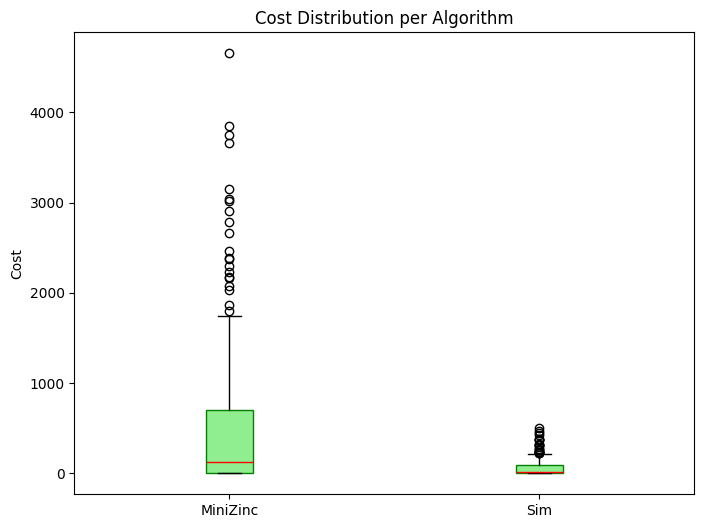

In [148]:
import matplotlib.pyplot as plt

# Prepare data
costs = [ev_df['mzn_cost'], ev_df['sim_cost']]

# Boxplot
plt.figure(figsize=(8,6))
plt.boxplot(costs, labels=['MiniZinc', 'Sim'], patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='green'),
            medianprops=dict(color='red'))

plt.title('Cost Distribution per Algorithm')
plt.ylabel('Cost')
plt.show()

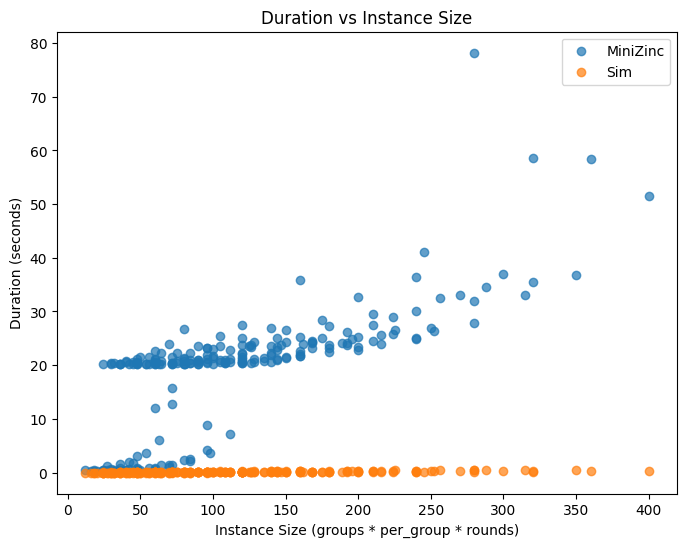

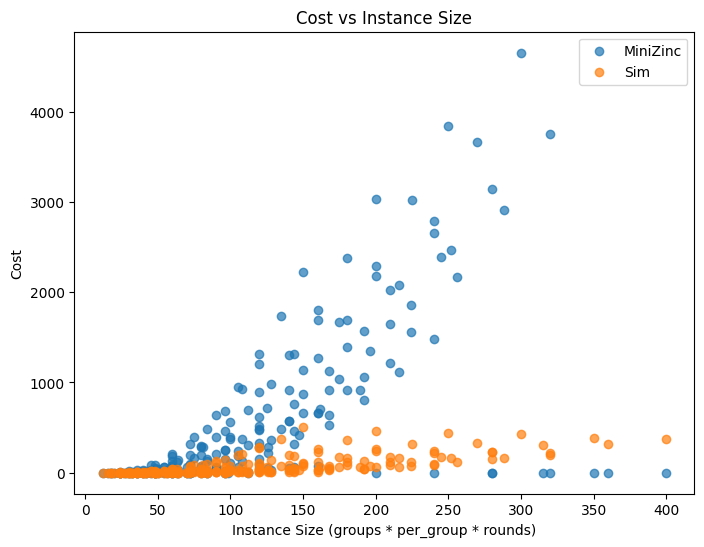

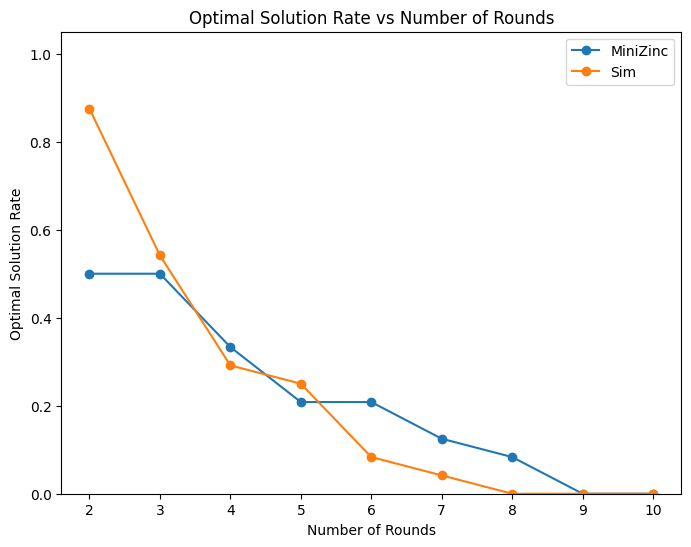

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Duration vs Problem Size ----
ev_df['instance_size'] = ev_df['n_groups'] * ev_df['n_per_group'] * ev_df['n_rounds']

plt.figure(figsize=(8,6))
plt.scatter(ev_df['instance_size'], ev_df['mzn_duration_seconds'], label='MiniZinc', alpha=0.7)
plt.scatter(ev_df['instance_size'], ev_df['sim_duration_seconds'], label='Sim', alpha=0.7)
plt.xlabel('Instance Size (groups * per_group * rounds)')
plt.ylabel('Duration (seconds)')
plt.title('Duration vs Instance Size')
plt.legend()
plt.show()

# ---- 2. Cost vs Problem Size ----
plt.figure(figsize=(8,6))
plt.scatter(ev_df['instance_size'], ev_df['mzn_cost'], label='MiniZinc', alpha=0.7)
plt.scatter(ev_df['instance_size'], ev_df['sim_cost'], label='Sim', alpha=0.7)
plt.xlabel('Instance Size (groups * per_group * rounds)')
plt.ylabel('Cost')
plt.title('Cost vs Instance Size')
plt.legend()
plt.show()

# ---- 3. Optimal Solution Rate per n_rounds ----
rounds = sorted(ev_df['n_rounds'].unique())
mzn_opt_rate = [ev_df[ev_df['n_rounds']==r]['mzn_optimal'].mean() for r in rounds]
sim_opt_rate = [ev_df[ev_df['n_rounds']==r]['sim_optimal'].mean() for r in rounds]

plt.figure(figsize=(8,6))
plt.plot(rounds, mzn_opt_rate, marker='o', label='MiniZinc')
plt.plot(rounds, sim_opt_rate, marker='o', label='Sim')
plt.xlabel('Number of Rounds')
plt.ylabel('Optimal Solution Rate')
plt.title('Optimal Solution Rate vs Number of Rounds')
plt.ylim(0,1.05)
plt.legend()
plt.show()